In [136]:
from modules import *
from functions import *

from decimal import Decimal
import pandas as pd

In [262]:
# def calculate_HR_scalings(n_ratios, ratio_max, R_start):      # shouldn't need this, that was for keeping the sum of j+k constant 
#     increment_H = 1 / n_ratios
#     increment_R = (1/ratio_max - R_start) ** (1 / (n_ratios - 1))
    
#     H_values = []; R_values = []
#     current_H = 0; current_R = R_start
    
#     for _ in range(n_ratios):
#         H_values.append(current_H)
#         R_values.append(current_R)
#         current_H += increment_H
#         current_R *= increment_R
        
#     return np.array(H_values), np.array(R_values)*100

def sliding_mean(matrix, window_size=10):
    N = matrix.shape[0]
    sliding_mean = np.zeros(N)
    for i in range(N):
        if i < window_size:
            sliding_mean[i] = np.median(matrix[:i+window_size])
        elif i > N - window_size:
            sliding_mean[i] = np.median(matrix[i-window_size:])
        else:
            sliding_mean[i] = np.median(matrix[i-window_size:i+window_size])
    return sliding_mean


In [5]:
""" Correlation in space of ratio vs. time - scaling ratios """

N = int(500)     

theta_stim = 90
n_trials = 20
n_thetas = 100
n_test_angles = 100

rand_scaling = 1
a=10
b=10

vars = np.random.lognormal(2, 0.6, N)
learning_rate = 1


def get_correlation(ratio, n_repeats):

    hebb_scaling = ratio * rand_scaling
    correlations = np.zeros((n_repeats, n_trials))

    for repeat in range(n_repeats):
        
        W_init = initialise_W(N, vars)
        W = np.zeros((N, N, n_trials+1)); W[:, :, 0] = W_init
        POs = []

        for trial in range(n_trials):
            W_old = W[:, :, trial]
            H = hebbian_component(N, W_old, n_thetas, theta_stim, type='stripe_rearing')
            eta = abs(np.random.randn(N, N))
            W_new = W_old + (hebb_scaling * H * propensity_hebb(W_old, a) + rand_scaling * eta * propensity_rand(W_old, b)) * learning_rate
            normalisation(W_new)
            W[:, :, trial+1] = W_new
            POs.append(get_preferred_orientations(N, W_old, n_angles=n_test_angles))

        preferences = np.array(POs).T 
        initial_preferences = np.linspace(0, 180, N) 
        initial_distances = np.abs(initial_preferences - theta_stim)
        total_drift = np.array([circular_distance(preferences[:, day], initial_preferences) for day in range(n_trials)]).T

        r_values = np.array([stats.linregress(initial_distances, total_drift[:, day])[2] for day in range(n_trials)])

        correlations[repeat, :] = r_values
    return np.mean(correlations, axis=0)

nx = n_trials
ny = 5

n_repeats = 1

r_matrix = np.zeros((ny, nx))

for i, ratio in enumerate(tqdm(np.linspace(0, 1, ny))):
    r_matrix[i, :] = get_correlation(ratio, n_repeats)

  0%|          | 0/5 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [49]:
# r_matrix = np.loadtxt('/Users/administrator/Library/CloudStorage/GoogleDrive-bh072197@gmail.com/My Drive/1/Drift/scripts/paper/correlation_ratio_time', delimiter=",")

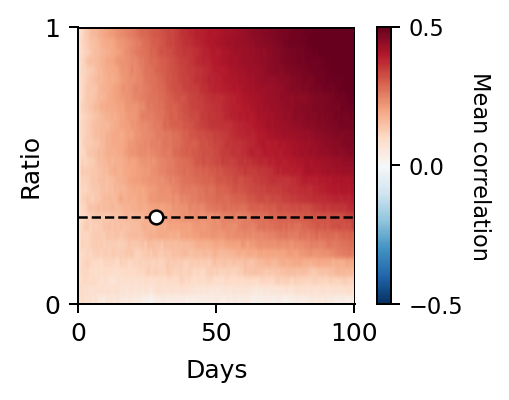

In [53]:
n_ticks = 3

n_trials = 100
nx = n_trials
ny = 30

fig, ax = plt.subplots(1, 1, figsize=(4, 2), dpi=180)
cbar_max = 0.5
im1 = ax.imshow(r_matrix,  cmap='RdBu_r', vmin=-cbar_max, vmax=cbar_max)
cbar = fig.colorbar(im1, ax=ax, fraction=0.026, pad=0.04)
cbar.ax.set_yticks(np.round(np.linspace(-cbar_max, cbar_max, 3), 1))
cbar.ax.tick_params(labelsize=9)
cbar.ax.set_ylabel(r'Mean correlation', rotation=-90, va="bottom", fontsize=9, labelpad=2)
ax.set_xlabel(r'Days', labelpad=5)
ax.set_ylabel(r'Ratio', labelpad=1)
ax.set_xticks(np.linspace(-0.5, nx, n_ticks)); ax.set_xticklabels((np.linspace(0, n_trials, n_ticks)).astype(int))
ax.set_yticks(np.linspace(-0.5, ny-0.2, 2)); ax.set_yticklabels((np.linspace(0, 1, 2).astype(int)))
ax.invert_yaxis()
ax.set_facecolor('k')

ax.set_ylim([-0.5, ny-0.2])
ax.set_xlim([-0.5, nx+0.3])

ax.axhline(0.3*ny, color='k', linestyle='--', linewidth=1)
ax.scatter(28, 9, ec='k', fc='w', s=30, zorder=3)
ax.set_aspect(1.0/ax.get_data_ratio()*1)

# plt.savefig('figures/ratio_vs_days.svg')


In [120]:
# np.savetxt('correlation_ratio_time', r_matrix, delimiter=",")

In [210]:
""" Correlation vs. effective ratio """

def get_correlation_and_ratio(hebb_scaling, rand_scaling, n_repeats, init_trials):

    effective_ratios = np.zeros((n_repeats, n_trials))
    correlations = np.zeros((n_repeats, n_trials))

    for repeat in range(n_repeats):
        vars = np.random.lognormal(2, 0.6, N)
        W_init = initialise_W(N, vars); W = W_init

        # initialisation period
        for trial in range(init_trials):
            H = hebbian_component(N, W, n_thetas, theta_stim, type='baseline')  
            eta = abs(np.random.randn(N, N))
            hebb = hebb_scaling * H * propensity_hebb(W, a)
            rand = rand_scaling * eta * propensity_rand(W, b)
            W = W + (hebb + rand) * learning_rate
            normalisation(W)

        # let's go
        W_post_init = W
        W = np.zeros((N, N, n_trials+1)); W[:, :, 0] = W_post_init
        POs = []

        for trial in range(n_trials):
            W_old = W[:, :, trial]
            H = hebbian_component(N, W_old, n_thetas, theta_stim, type='stripe_rearing')  
            eta = abs(np.random.randn(N, N))
            hebb = hebb_scaling * H * propensity_hebb(W_old, a)
            rand = rand_scaling * eta * propensity_rand(W_old, b)
            W_new = W_old + (hebb + rand) * learning_rate
            normalisation(W_new)
            W[:, :, trial+1] = W_new
            POs.append(get_preferred_orientations(N, W_old, n_angles=n_test_angles))

            hebb_with_normalisation = (hebb - W_old * np.sum(hebb, axis=0))
            rand_with_normalisation = (rand - W_old * np.sum(rand, axis=0))
            hebb_without_normalisation = hebb 
            rand_without_normalisation = rand

            # effective_ratios[repeat, trial] = np.mean(np.abs(hebb_with_normalisation))  / (np.mean(np.abs(rand_with_normalisation))  + 1e-10)   # then try with abs 
            effective_ratios[repeat, trial] = np.mean(hebb_without_normalisation) / (np.mean(rand_without_normalisation) + 1e-10)

        preferences = np.array(POs).T 
        initial_preferences = np.linspace(0, 180, N) 
        initial_distances = np.abs(initial_preferences - theta_stim)
        total_drift = np.array([circular_distance(preferences[:, day], initial_preferences) for day in range(n_trials)]).T
        r_values = np.array([stats.linregress(initial_distances, total_drift[:, day])[2] for day in range(n_trials)])
        correlations[repeat, :] = r_values

    return correlations, effective_ratios


In [211]:
N = 500
rand_scaling = 1
n_test_angles = 100

n_trials = 50       # nx
n_ratios = 50        # ny 
n_repeats = 30

hebb_scalings = np.linspace(0, 1, n_ratios)

correlations_matrix = np.zeros((n_repeats, n_trials, n_ratios))
ratios_matrix = np.zeros((n_repeats, n_trials, n_ratios))

for i, hebb_scaling in enumerate(tqdm(hebb_scalings)):
    # rand_scaling = rand_scalings[i]
    correlations, ratios = get_correlation_and_ratio(hebb_scaling, rand_scaling, n_repeats, init_trials=20)
    correlations_matrix[:, :, i] = correlations; ratios_matrix[:, :, i] = ratios

 32%|███▏      | 16/50 [2:21:08<4:59:56, 529.30s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Ratio H:R')

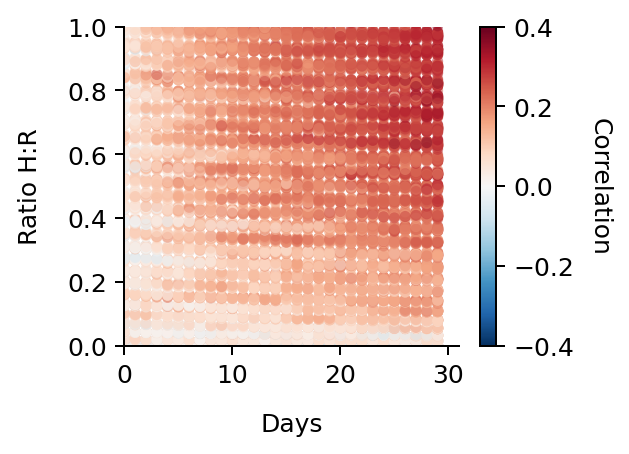

In [250]:
correlations_matrix = np.loadtxt('correlations_matrix', delimiter=",").reshape(50, 30, 30)
ratios_matrix = np.loadtxt('ratios_matrix',  delimiter=",").reshape(30, 30, 30)

fig, ax = plt.subplots(figsize=(3, 2.3), dpi=180)

for i, ratio in enumerate(np.linspace(0, 1, n_ratios)):
    for repeat in range(30):
        ax.scatter(np.arange(0, n_trials), ratios_matrix[repeat, :, i], c=correlations_matrix[repeat, :, i]*1.1, ec=None, cmap='RdBu_r', vmin=-0.4, vmax=0.4, s=20, alpha=0.5, clip_on=True)

# add colorbar
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-0.4, vmax=0.4))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, pad=0.05, aspect=20, shrink=1)
cbar.set_label("Correlation", rotation=270, labelpad=15)

ax.set_ylim(0, 1)
ax.set_xlim(0, n_trials+1)
ax.set_xlabel("Days")
ax.set_ylabel("Ratio H:R")

Text(0, 0.5, 'Ratio H:R')

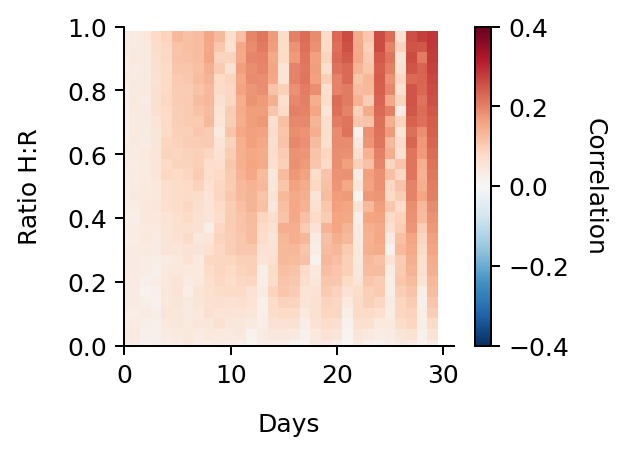

In [261]:
correlations_matrix = np.loadtxt('correlations_matrix', delimiter=",").reshape(50, 30, 30)   # size = (n_repeats, n_trials, n_ratios)
ratios_matrix = np.loadtxt('ratios_matrix', delimiter=",").reshape(30, 30, 30)

# Convert the scatter points to an imshow grid by mapping to discrete intervals 

n_intervals = 30
n_repeats = 30
n_trials = 30
n_ratios = 30

ratio_intervals = np.linspace(0, 1, n_intervals)

fig, ax = plt.subplots(figsize=(3, 2.3), dpi=180)

discrete_interval_matrix = np.zeros((n_repeats, n_trials, n_ratios))

for repeat in range(n_repeats):
    for row in range(n_trials):
        for i in range(n_ratios):
            ratio = ratios_matrix[repeat, row, i]
            col = (np.abs(ratio_intervals - ratio)).argmin()
            discrete_interval_matrix[repeat, row, col] = correlations_matrix[repeat, row, col]

im = ax.imshow(np.mean(discrete_interval_matrix, axis=0), cmap='RdBu_r', vmin=-0.4, vmax=0.4)
ax.invert_yaxis()

cbar = fig.colorbar(im, ax=ax, pad=0.05, aspect=20, shrink=1)
cbar.set_label("Correlation", rotation=270, labelpad=15)

ax.set_ylim(0, n_ratios)
ax.set_yticks(np.linspace(0, n_ratios, 6)); ax.set_yticklabels(np.round(np.linspace(0, 1, 6), 2))
ax.set_xlim(0, n_trials+1)
ax.set_xlabel("Days")
ax.set_ylabel("Ratio H:R")


In [92]:
""" Magnitude vs. effective ratio """

def get_magnitude_and_ratio(hebb_scaling, rand_scaling, n_repeats, init_trials):

    effective_ratios = np.zeros((n_repeats, n_trials))
    magnitudes = np.zeros((n_repeats, n_trials))

    for repeat in range(n_repeats):
        vars = np.random.lognormal(2, 0.6, N)
        W_init = initialise_W(N, vars); W = W_init

        # initialisation period
        for trial in range(init_trials):
            H = hebbian_component(N, W, n_thetas, theta_stim, type='baseline')  
            eta = abs(np.random.randn(N, N))
            hebb = hebb_scaling * H * propensity_hebb(W, a)
            rand = rand_scaling * eta * propensity_rand(W, b)
            W = W + (hebb + rand) * learning_rate
            normalisation(W)

        # let's go
        W_post_init = W
        W = np.zeros((N, N, n_trials+1)); W[:, :, 0] = W_post_init
        POs = []

        for trial in range(n_trials):
            W_old = W[:, :, trial]
            H = hebbian_component(N, W_old, n_thetas, theta_stim, type='baseline')  
            eta = abs(np.random.randn(N, N))
            hebb = hebb_scaling * H * propensity_hebb(W_old, a)
            rand = rand_scaling * eta * propensity_rand(W_old, b)
            W_new = W_old + (hebb + rand) * learning_rate
            normalisation(W_new)
            W[:, :, trial+1] = W_new
            POs.append(get_preferred_orientations(N, W_old, n_angles=n_test_angles))

            hebb_with_normalisation = (hebb - W_old * np.sum(hebb, axis=0))
            rand_with_normalisation = (rand - W_old * np.sum(rand, axis=0))
            hebb_without_normalisation = hebb 
            rand_without_normalisation = rand
        
            # effective_ratios[repeat, trial] = np.mean(np.abs(hebb_with_normalisation))  / (np.mean(np.abs(rand_with_normalisation))  + 1e-10)   # then try with abs 
            effective_ratios[repeat, trial] = np.mean(hebb_without_normalisation) / (np.mean(rand_without_normalisation) + 1e-10)

        preferences = np.array(POs).T 
        initial_preferences = np.linspace(0, 180, N) 
        initial_distances = np.abs(initial_preferences - theta_stim)
        total_drift = np.array([circular_distance(preferences[:, day], initial_preferences) for day in range(n_trials)]).T

        absolute_change = np.array([circular_distance(preferences[:, day], initial_preferences) for day in range(n_trials)])
        median_change_per_day = np.array([np.median(x) for x in absolute_change])
        magnitudes[repeat, :] = median_change_per_day

    return magnitudes, effective_ratios


In [93]:
N = 500
n_test_angles = 100
rand_scaling = 1

n_trials = 30       # nx
n_ratios = 30       # ny 

n_repeats = 1

hebb_scalings = np.linspace(0, 1, n_ratios)

magnitudes_matrix = np.zeros((n_repeats, n_trials, n_ratios))
ratios_matrix = np.zeros((n_repeats, n_trials, n_ratios))

for i, hebb_scaling in enumerate(tqdm(hebb_scalings)):
    magnitudes, ratios = get_magnitude_and_ratio(hebb_scaling, rand_scaling, n_repeats, init_trials=20)
    magnitudes_matrix[:, :, i] = magnitudes; ratios_matrix[:, :, i] = ratios

  7%|▋         | 2/30 [00:56<13:11, 28.26s/it]


KeyboardInterrupt: 

In [237]:
# np.savetxt('magnitudes_matrix', magnitudes_matrix.reshape((n_repeats, n_trials * n_ratios)), delimiter=",")
# np.savetxt('ratios_matrix', ratios_matrix.reshape((n_repeats, n_trials * n_ratios)), delimiter=",")
# np.savetxt('correlations_matrix', correlations_matrix.reshape((n_repeats, n_trials * n_ratios)), delimiter=",")

Text(0, 0.5, 'Effective ratio H:R')

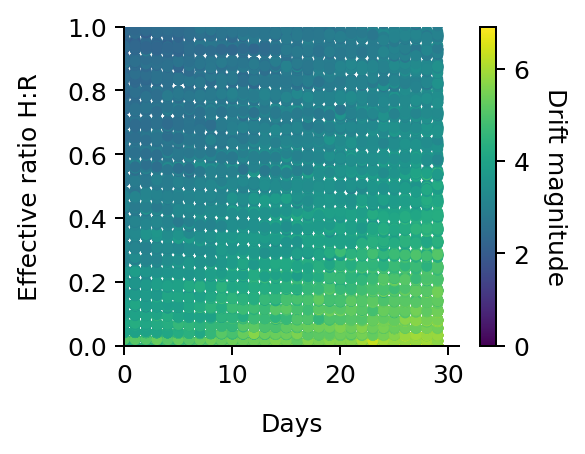

In [116]:
magnitudes_matrix = np.loadtxt('magnitudes_matrix',  delimiter=",").reshape(30, 30, 30)

fig, ax = plt.subplots(figsize=(3, 2.3), dpi=180)

for i, ratio in enumerate(np.linspace(0, 1, n_ratios)):
    for repeat in range(30):
        ax.scatter(np.arange(0, n_trials), ratios_matrix[repeat, :, i], c=magnitudes_matrix[repeat, :, i], ec=None, cmap='viridis', vmin=0, vmax=np.max(magnitudes_matrix), s=20, alpha=1, clip_on=True)

# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=np.max(magnitudes_matrix)))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, pad=0.05, aspect=20, shrink=1)
cbar.set_label("Drift magnitude", rotation=270, labelpad=15)

ax.set_ylim(0, 1)
ax.set_xlim(0, n_trials+1)
ax.set_xlabel("Days")
ax.set_ylabel("Effective ratio H:R")

In [164]:
# open fig1g-data.csv
data_magnitudes = np.array(pd.read_csv('fig1g-data.csv', header=None))
data_magnitudes_mean = data_magnitudes[2:14, 0]
data_magnitudes_lower_bound = data_magnitudes[2:14, 1]
data_magnitudes_upper_bound = data_magnitudes[2:14, 2]
data_days = np.arange(1, 25, 2)

In [202]:
# interactive 3D plot with plotly of days, ratio and magnitudes

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=1, specs=[[{'is_3d': True}]])
fig.update_layout(width=800, height=800, autosize=True, margin=dict(l=0, r=0, b=0, t=0))

for i, ratio in enumerate(np.linspace(0, 1, n_ratios)):
    # for repeat in range(30):
        # fig.add_trace(go.Scatter3d(x=np.arange(0, n_trials), y=np.ones(n_trials) * ratio, z=(magnitudes_matrix[repeat, :, i]), mode='markers', marker=dict(size=2, color=magnitudes_matrix[repeat, :, i], colorscale='viridis', cmin=0, cmax=np.max(magnitudes_matrix))), row=1, col=1)
    fig.add_trace(go.Scatter3d(x=np.arange(0, n_trials), y=np.ones(n_trials) * ratio, z=(np.mean(magnitudes_matrix[:, :, i], axis=0)), mode='markers', marker=dict(size=5, color=magnitudes_matrix[repeat, :, i], colorscale='viridis', cmin=0, cmax=np.max(magnitudes_matrix))), row=1, col=1)

# create plane of data_days vs. data_magnitudes_mean 
fig.add_trace(go.Surface(x=data_days, y=np.linspace(0, 1, n_ratios), z=np.tile(data_magnitudes_mean, (n_ratios, 1)), colorscale='viridis', showscale=False,  opacity=0.8), row=1, col=1)

fig.update_traces(showlegend=False)
fig.update_layout(scene=dict(xaxis_title='Days', yaxis_title='Effective ratio H:R', zaxis_title='Drift magnitude'), scene_aspectmode='cube')
fig.show()





In [220]:
""" Comparison of ratio under baseline and deprivation """

def get_ratio(hebb_scaling, rand_scaling, n_repeats, init_trials, condition):

    hebbs = np.zeros((n_repeats, n_trials, N, N))
    rands = np.zeros((n_repeats, n_trials, N, N))

    for repeat in range(n_repeats):
        vars = np.random.lognormal(2, 0.6, N)
        W_init = initialise_W(N, vars); W = W_init

        # initialisation period
        for trial in range(init_trials):
            H = hebbian_component(N, W, n_thetas, theta_stim, type='baseline')  
            eta = abs(np.random.randn(N, N))
            hebb = hebb_scaling * H * propensity_hebb(W, a)
            rand = rand_scaling * eta * propensity_rand(W, b)
            W = W + (hebb + rand) * learning_rate
            normalisation(W)

        # let's go
        W_post_init = W
        W = np.zeros((N, N, n_trials+1)); W[:, :, 0] = W_post_init

        for trial in range(n_trials):
            W_old = W[:, :, trial]
            H = hebbian_component(N, W_old, n_thetas, theta_stim, type=condition)  
            eta = abs(np.random.randn(N, N))
            hebb = hebb_scaling * H * propensity_hebb(W_old, a)
            rand = rand_scaling * eta * propensity_rand(W_old, b)
            W_new = W_old + (hebb + rand) * learning_rate
            normalisation(W_new)
            W[:, :, trial+1] = W_new

            hebb_with_normalisation = (hebb - W_old * np.sum(hebb, axis=0))
            rand_with_normalisation = (rand - W_old * np.sum(rand, axis=0))

            hebbs[repeat, trial, :, :] = hebb # hebb_with_normalisation
            rands[repeat, trial, :, :] = rand # rand_with_normalisation

    return hebbs, rands


In [222]:
N = 300

rand_scaling = 1
n_trials = 30       # nx
n_ratios = 10        # ny 

n_repeats = 1

hebb_scalings, rand_scalings = calculate_HR_scalings(n_ratios, ratio_max=1, R_start=0.01)

hebbs_matrix_baseline = np.zeros((n_repeats, n_trials, N, N, n_ratios))
hebbs_matrix_deprivation = np.zeros((n_repeats, n_trials, N, N, n_ratios))

rands_matrix_baseline = np.zeros((n_repeats, n_trials, N, N, n_ratios))
rands_matrix_deprivation = np.zeros((n_repeats, n_trials, N, N, n_ratios))

for i, hebb_scaling in enumerate(tqdm(hebb_scalings)):
    # rand_scaling = rand_scalings[i]
    hebbs_matrix_baseline[:, :, :, :, i], rands_matrix_baseline[:, :, :, :, i] = get_ratio(hebb_scaling, rand_scaling, n_repeats, init_trials=20, condition='baseline')
    hebbs_matrix_deprivation[:, :, :, :, i], rands_matrix_deprivation[:, :, :, :, i] = get_ratio(hebb_scaling, rand_scaling, n_repeats, init_trials=20, condition='stripe_rearing')

100%|██████████| 10/10 [01:19<00:00,  7.91s/it]


In [226]:
np.linspace(0, 1, n_ratios)

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


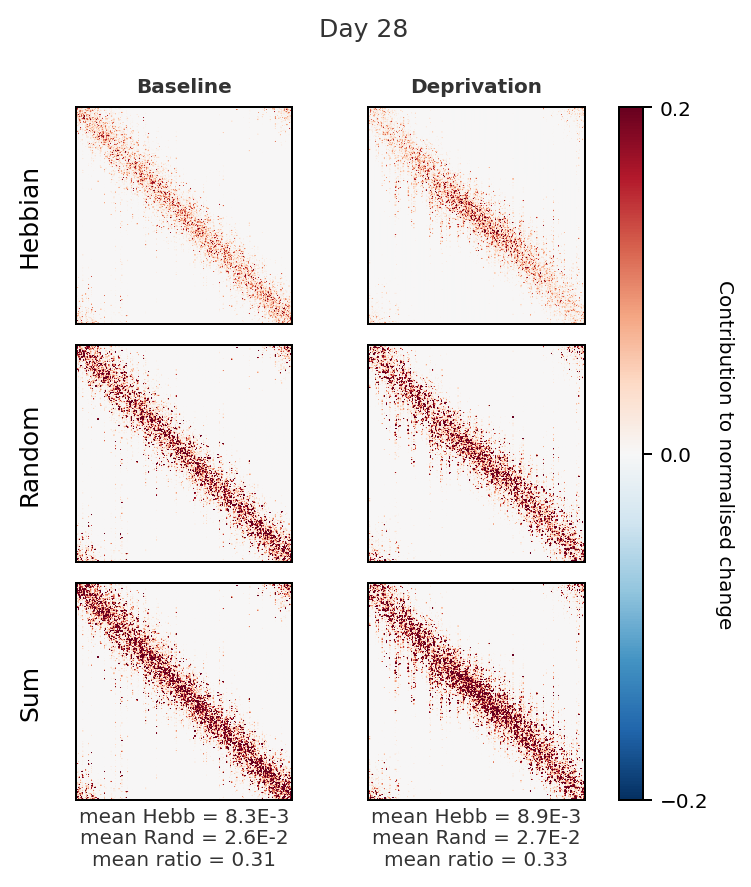

In [224]:
""" Plot Hebb, rand and sum contribution per synapse """

# for n_trial in range(50):

n_trial = 28
fig, ax = plt.subplots(3, 2, figsize=(5, 5), dpi=180)

cbarlim = 0.2
n_ratio = 4
repeat = 0

ax[0, 0].imshow(hebbs_matrix_baseline[repeat, n_trial, :, :, n_ratio], cmap='RdBu_r', vmin=-cbarlim, vmax=cbarlim)
ax[0, 1].imshow(hebbs_matrix_deprivation[repeat, n_trial, :, :, n_ratio], cmap='RdBu_r', vmin=-cbarlim, vmax=cbarlim)
ax[1, 0].imshow(rands_matrix_baseline[repeat, n_trial, :, :, n_ratio],  cmap='RdBu_r', vmin=-cbarlim, vmax=cbarlim)
ax[1, 1].imshow(rands_matrix_deprivation[repeat, n_trial, :, :, n_ratio],  cmap='RdBu_r', vmin=-cbarlim, vmax=cbarlim)
ax[2, 0].imshow(hebbs_matrix_baseline[repeat, n_trial, :, :, n_ratio] + rands_matrix_baseline[repeat, n_trial, :, :, n_ratio], cmap='RdBu_r', vmin=-cbarlim, vmax=cbarlim)
ax[2, 1].imshow(hebbs_matrix_deprivation[repeat, n_trial, :, :, n_ratio] + rands_matrix_deprivation[repeat, n_trial, :, :, n_ratio], cmap='RdBu_r', vmin=-cbarlim, vmax=cbarlim)

# at the bottom of both columns, add text with the mean of each hebbian and random matrix in scientific notation
for axis, matrix in zip(ax[2], [hebbs_matrix_baseline, hebbs_matrix_deprivation]):
    axis.text(0.5, -0.1, f"mean Hebb = {Decimal(np.mean(matrix[repeat, n_trial, :, :, n_ratio])):.1E}", size=8, ha="center", transform=axis.transAxes)

for axis, matrix in zip(ax[2], [rands_matrix_baseline, rands_matrix_deprivation]):
    axis.text(0.5, -0.2, f"mean Rand = {Decimal(np.mean(matrix[repeat, n_trial, :, :, n_ratio])):.1E}", size=8, ha="center", transform=axis.transAxes)

ax[2, 0].text(0.5, -0.3, f"mean ratio = {(np.mean(hebbs_matrix_baseline[repeat, n_trial, :, :, n_ratio]) / np.mean(rands_matrix_baseline[repeat, n_trial, :, :, n_ratio])):.2f}", size=8, ha="center", transform=ax[2, 0].transAxes)
ax[2, 1].text(0.5, -0.3, f"mean ratio = {(np.mean(hebbs_matrix_deprivation[repeat, n_trial, :, :, n_ratio]) / np.mean(rands_matrix_deprivation[repeat, n_trial, :, :, n_ratio])):.2f}", size=8, ha="center", transform=ax[2, 1].transAxes)


# add trial as title for whole plot
fig.suptitle(f"Day {n_trial}", fontsize=10)
# set title for columns as "Baseline" and "Deprivation", and for rows as "Hebbian" and "Random"
for axis, title in zip(ax[0], ["Baseline", "Deprivation", "Sum"]):
    axis.set_title(title, fontweight='bold', fontsize=8)
for axis, title in zip(ax[:, 0], ["Hebbian", "Random", "Sum"]):
    axis.set_ylabel(title)

for axis in ax.flat:
    # no ticks or tick labels for subplots
    axis.set_xticks([])
    axis.set_yticks([])
    sns.despine(ax=axis, right=False, top=False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# colorbar
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-cbarlim, vmax=cbarlim))
sm._A = []
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), shrink=1, pad=0.05, aspect=30)
cbar.ax.tick_params(labelsize=8)
cbar.set_ticks([-cbarlim, 0, cbarlim])
cbar.set_label('Contribution to normalised change', rotation=270, fontsize=8, labelpad=10)
# plt.savefig(f"figures/without_norm_HR_scaling_trial_{n_trial}.png", dpi=300)
# plt.close()

# save data as csv files
# np.savetxt("without_norm_hebbs_matrix_baseline.csv", hebbs_matrix_baseline[0, n_trial, :, :, n_ratio], delimiter=",")
# np.savetxt("without_norm_hebbs_matrix_deprivation.csv", hebbs_matrix_deprivation[0, n_trial, :, :, n_ratio], delimiter=",")
# np.savetxt("without_norm_rands_matrix_baseline.csv", rands_matrix_baseline[0, n_trial, :, :, n_ratio], delimiter=",")
# np.savetxt("without_norm_rands_matrix_deprivation.csv", rands_matrix_deprivation[0, n_trial, :, :, n_ratio], delimiter=",")



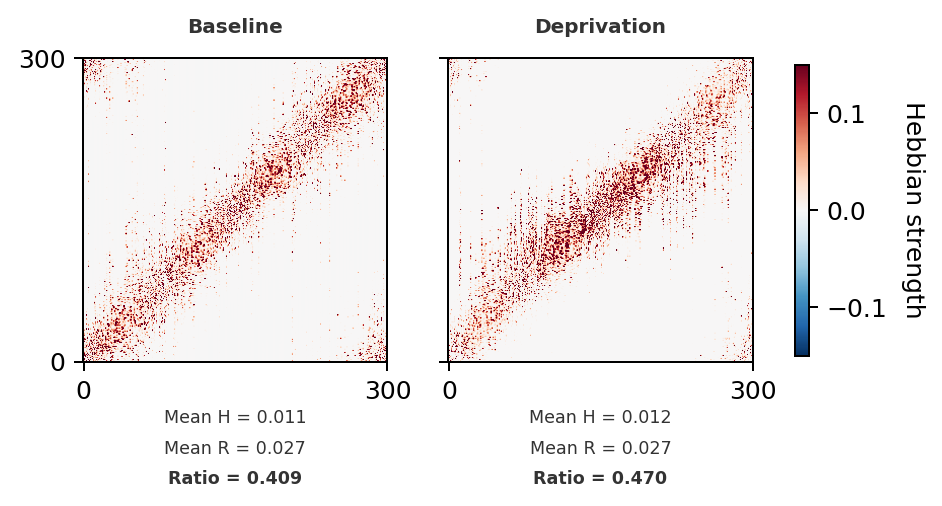

In [22]:
# # two subplots sharing both x/y axes
# fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=180, sharex=True, sharey=True)

# cbarlim = 0.15
# n_trial = -1
# n_ratio = 5

# ax[0].imshow(np.mean(hebbs_matrix_baseline[:2, n_trial, :, :, n_ratio], axis=0), cmap='RdBu_r', vmin=-cbarlim, vmax=cbarlim)
# ax[1].imshow(np.mean(hebbs_matrix_deprivation[:2, n_trial, :, :, n_ratio], axis=0), cmap='RdBu_r', vmin=-cbarlim, vmax=cbarlim)

# sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-cbarlim, vmax=cbarlim)); sm._A = []
# cbar = fig.colorbar(sm, ax=ax, pad=0.05, aspect=20, shrink=0.7)
# cbar.set_label("Hebbian strength", rotation=270, labelpad=15)

# ax[0].set_title("Baseline", fontsize=8, fontweight='bold', pad=10)
# ax[1].set_title("Deprivation", fontsize=8, fontweight='bold', pad=10)

# # print mean of hebb underneath each plot
# ax[0].text(0.5, -0.2, "Mean H = %.3f" % np.mean(hebbs_matrix_baseline[:, n_trial, :, :, n_ratio]), fontsize=7, transform=ax[0].transAxes, ha='center') # fontweight='bold')
# ax[1].text(0.5, -0.2, "Mean H = %.3f" % np.mean(hebbs_matrix_deprivation[:, n_trial, :, :, n_ratio]), fontsize=7, transform=ax[1].transAxes, ha='center') #, fontweight='bold')

# # print mean of rand underneath each plot
# ax[0].text(0.5, -0.3, "Mean R = %.3f" % np.mean(rands_matrix_baseline[:, n_trial, :, :, n_ratio]), fontsize=7, transform=ax[0].transAxes, ha='center') 
# ax[1].text(0.5, -0.3, "Mean R = %.3f" % np.mean(rands_matrix_deprivation[:, n_trial, :, :, n_ratio]), fontsize=7, transform=ax[1].transAxes, ha='center') 

# # print ratio of hebb/rand underneath each plot
# ax[0].text(0.5, -0.4, "Ratio = %.3f" % (np.mean(hebbs_matrix_baseline[:, n_trial, :, :, n_ratio])/np.mean(rands_matrix_baseline[:, n_trial, :, :, n_ratio])), fontsize=7, transform=ax[0].transAxes, ha='center', fontweight='bold')
# ax[1].text(0.5, -0.4, "Ratio = %.3f" % (np.mean(hebbs_matrix_deprivation[:, n_trial, :, :, n_ratio])/np.mean(rands_matrix_deprivation[:, n_trial, :, :, n_ratio])), fontsize=7, transform=ax[1].transAxes, ha='center', fontweight='bold')

# for ax in ax:
#     # ax.set_xticks([]); ax.set_yticks([])
#     ax.set_xticks([N, 0]); ax.set_yticks([N, 0])
#     ax.spines['right'].set_visible(True); ax.spines['top'].set_visible(True)

# ax.invert_yaxis()


In [209]:
""" Plot mean Hebb and mean ratio over sliding window for each trial """

for n_trial in range(50):

    # n_trial = -1

    n_ratio = 4
    sliding_window = 10

    fig, ax = plt.subplots(1, 2, figsize=(6, 2), dpi=180)

    mean_ratio_baseline  = np.mean(hebbs_matrix_baseline[:, n_trial, :, :, n_ratio])/np.mean(rands_matrix_baseline[:, n_trial, :, :, n_ratio])
    mean_ratio_deprivation  = np.mean(hebbs_matrix_deprivation[:, n_trial, :, :, n_ratio])/np.mean(rands_matrix_deprivation[:, n_trial, :, :, n_ratio])

    ax[0].plot(sliding_mean(hebbs_matrix_baseline[0, n_trial, :, :, n_ratio], sliding_window), color='k')
    ax[1].plot(sliding_mean(hebbs_matrix_deprivation[0, n_trial, :, :, n_ratio], sliding_window), color='k')

    ax[0].set_title("Baseline", fontsize=8, fontweight='bold', pad=10)
    ax[1].set_title("Deprivation", fontsize=8, fontweight='bold', pad=10)

    # ax[0].set_ylim(0, 0.03)
    # ax[1].set_ylim(0, 0.03)
    ax[0].set_xlim(0, N)
    ax[1].set_xlim(0, N)

    ax[0].set_ylabel("Hebbian strength")
    ax[0].set_xlabel("Neuron")
    ax[1].set_xlabel("Neuron")

    ax2 = ax[0].twinx()
    ax2.plot(sliding_mean(hebbs_matrix_baseline[0, n_trial, :, :, n_ratio], sliding_window) / sliding_mean(rands_matrix_baseline[0, n_trial, :, :, n_ratio], 10), color='r')
    ax2.set_ylabel("Ratio")
    ax2.spines['right'].set_visible(True)
    ax2.yaxis.label.set_color('r')
    ax2.tick_params(axis='y', colors='r')
    # ax2.set_ylim(0, 1)

    ax3 = ax[1].twinx()
    ax3.plot(sliding_mean(hebbs_matrix_deprivation[0, n_trial, :, :, n_ratio], sliding_window) / sliding_mean(rands_matrix_deprivation[0, n_trial, :, :, n_ratio], 10), color='r')
    ax3.set_ylabel("Ratio")
    ax3.spines['right'].set_visible(True)
    ax3.yaxis.label.set_color('r')
    ax3.tick_params(axis='y', colors='r')
    # ax3.set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig(f"figures/ratio_trial_{n_trial}.png", dpi=300)
    plt.close()


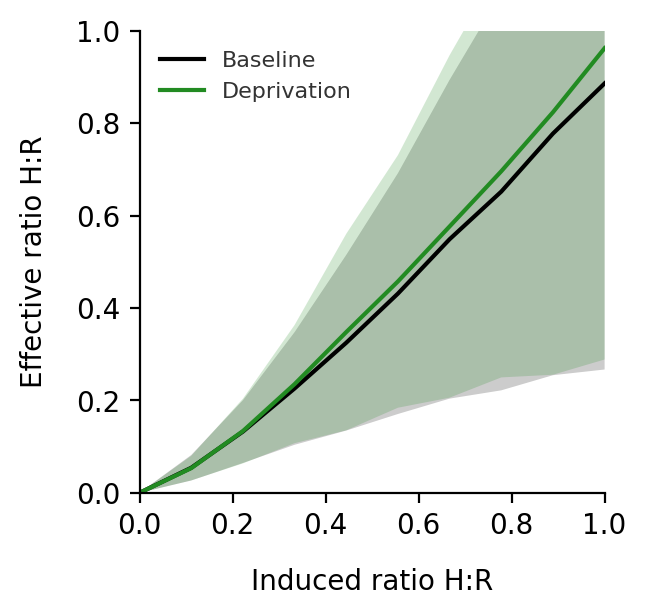

In [21]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

n_trial = -1

effective_ratios_baseline = [np.mean(hebbs_matrix_baseline[:, n_trial, :, :, i])/np.mean(rands_matrix_baseline[:, n_trial, :, :, i]) for i in range(n_ratios)]
effective_ratios_deprivation = [np.mean(hebbs_matrix_deprivation[:, n_trial, :, :, i])/np.mean(rands_matrix_deprivation[:, n_trial, :, :, i]) for i in range(n_ratios)]

effective_ratios_baseline_std = [np.std(hebbs_matrix_baseline[:, n_trial, :, :, i])/np.std(rands_matrix_baseline[:, n_trial, :, :, i]) for i in range(n_ratios)]
effective_ratios_deprivation_std = [np.std(hebbs_matrix_deprivation[:, n_trial, :, :, i])/np.std(rands_matrix_deprivation[:, n_trial, :, :, i]) for i in range(n_ratios)]

ax.plot(np.linspace(0, 1, n_ratios), effective_ratios_baseline, c='k', label='Baseline')
ax.plot(np.linspace(0, 1, n_ratios), effective_ratios_deprivation, c='forestgreen', label='Deprivation')

ax.fill_between(np.linspace(0, 1, n_ratios), np.array(effective_ratios_baseline) - np.array(effective_ratios_baseline_std), np.array(effective_ratios_baseline) + np.array(effective_ratios_baseline_std), fc='k', ec=None, alpha=0.2)
ax.fill_between(np.linspace(0, 1, n_ratios), np.array(effective_ratios_deprivation) - np.array(effective_ratios_deprivation_std), np.array(effective_ratios_deprivation) + np.array(effective_ratios_deprivation_std), fc='forestgreen', ec=None, alpha=0.2)

ax.set_xlabel('Induced ratio H:R'); ax.set_ylabel('Effective ratio H:R')
ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.legend(loc='upper left', fontsize=8, frameon=False)